--- 
# Post-crop Processing  
---  

After establishing a bounding box for the road sign, the image is cropped. In principle, this can result in bounding boxes with very different dimentions. Feeding these different-sized images into an image detection algorithm can be handled by various approaches, for example:
* Leave the images and feed variable sizes into the image detection step
* Re-size images and/or deform images  

In the context of this dataset, we decided that re-sizing images to a standard crop size would be one of the most acceptable approaches. It's important to note:
* Instead of simply filling-in with null data, target images are "stretched" to fit the standard crop (so as to not bias the detection with lots of empty data). 
* This allows us to augment the dataset (add new entries to the dataset through deformations) including flipping and rotating images (with blur or gamma adjustments) or even projective transformations.

In [1]:
# Requirements
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow

import cv2
import matplotlib.pyplot as plt
import sys
%matplotlib inline

---  
# Step 1: Explore Training Dataset
---

This dataset came with training examples of bounding boxes. For this exploration we'll:
1. Crop the training set images accordingly
2. Use the cropped images as our starting point

In [5]:
# load CSV with bounding boxes
train_df = pd.read_csv("../data/train.csv")
train_df.head()

,Img_Name,Top,Left,Width,Height,Label
0,02-25 13.26.44.jpg,131,1687,163,163,Speed Limit 80
1,02-25 13.33.43.jpg,399,256,36,33,Speed Limit 50
2,02-25 13.37.16.jpg,400,249,44,44,Speed Limit 50
3,02-25 14.21.59.jpg,392,458,34,32,Speed Limit 50
4,02-25 14.25.06.jpg,332,232,78,72,Speed Limit 50


Counts of each sign type:
 Speed Limit 50    120
Speed Limit 40    110
Speed Limit 30     80
Speed Limit 20     65
Speed Limit 80     49
Speed Limit 60     44
Name: Label, dtype: int64


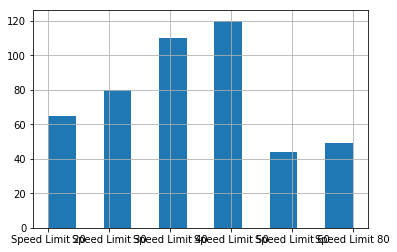

In [55]:
# distribution of classes
print("Counts of each sign type:\n",train_df['Label'].value_counts())
train_df["Label"].hist(bins=11)

Note:
* The most numerous sign types are the 40km/hr and 50km/hr
* The least numerous sign types are 60km/hr and 80km/hr
* There are roughly **3 times** more *40's and 50's* than *60's and 80's*

## Bounding boxes

In [3]:
# max width of a bounding box
print ("width  by height")
print (train_df['Width'].max(),"px by",train_df['Height'].max(),"px")

width  by height
191 px by 244 px


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1142d1278>,
      dtype=object)

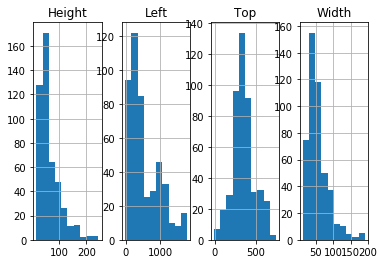

In [5]:
# distribution of values
train_df.hist(layout=(1,4))

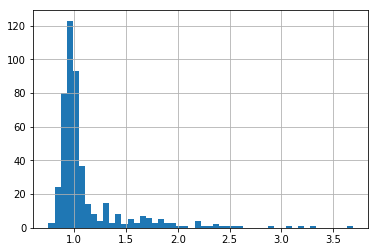

In [6]:
# height/width ratio
train_df["HWratio"] = round(train_df["Height"]/train_df["Width"],2)
train_df["HWratio"].hist(bins=50)

Note:
* Height/Width ratio = 1 means a **square box**
* Height/Width ratio > 1 means a _taller_ image
* Height/Width ratio < 1 means a _fatter_ image

Most of the images in the training dataset are square-ish; the outliers at the extremes seem to be skewed by almost 4x (four times as tall than they are wide).

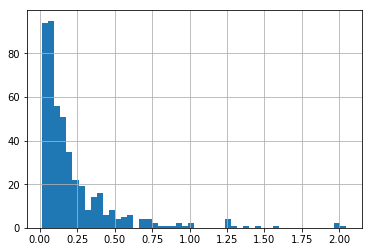

In [19]:
# crop ratio (percent of original image used)
train_df["%_image_used"] = 100*(train_df["Width"]*train_df["Height"])/(1080*1920)
train_df["%_image_used"].hist(bins=50)

Most images use very little of the entire image (less than 0.25% of the entire image)

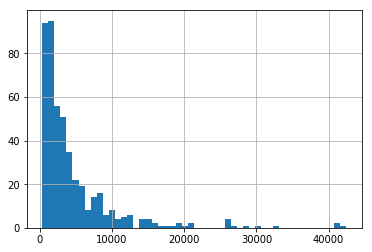

In [18]:
# size of cropped image
train_df["crop_total_pixels"] = train_df["Width"]*train_df["Height"]
train_df["crop_total_pixels"].hist(bins=50)

The vast majority of the cropped images are rather small (< 5,000pixels). That is, most of the cropped images are smaller than **250px by 250px**

## Cropping

Filename:  02-25 13.26.44.jpg
Bounding Box: (Top,Left,Width,Height) 131 1687 163 163
Image Dimensions:  (1920, 1080)


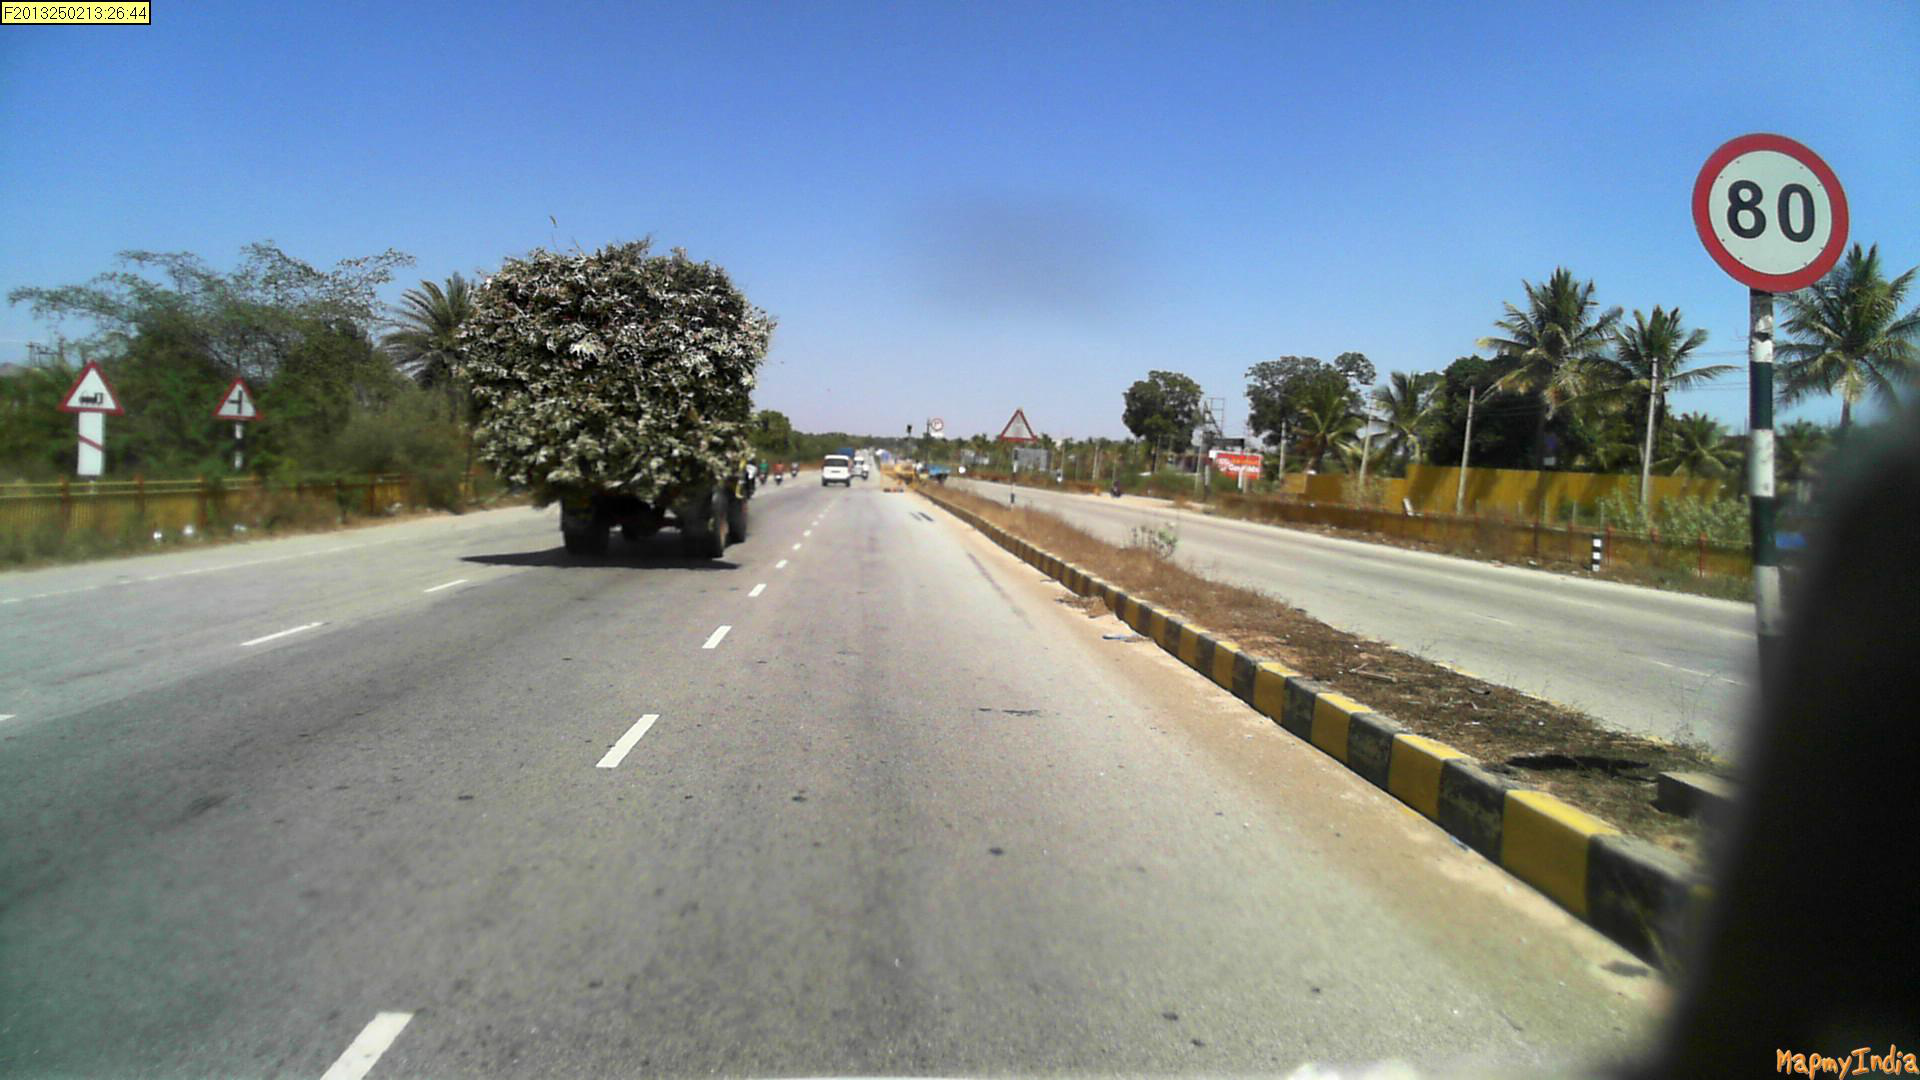

Bounding Pixels:  (1687, 131, 1850, 294)


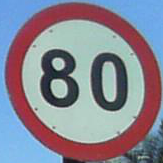

In [9]:
# crop example image to verify working
for index,row in train_df[:1].iterrows():
    
    # open file
    file = row.Img_Name
    image = Image.open("../data/train/%s" % file, 'r')
    
    # print image
    print ("Filename: ", file)
    print ("Bounding Box: (Top,Left,Width,Height)", row.Top, row.Left, row.Width, row.Height)
    print ("Image Dimensions: ", image.size)
    display(image)
    
    # crop + dispaly cropped
    width, height = image.size
    right = (row.Left + row.Width)
    lower = (row.Top + row.Height)
    box = (row.Left, row.Top, right, lower)
    
    print ("Bounding Pixels: ", box)
    image_crop = image.crop(box)
    display(image_crop)

In [10]:
# crop all images and save them

def savecrop(path, file):
    '''
    To be used inside a for loop (iterating over each row)
    Saves cropped image to file in same folder.
    Use example: ` boxcrop("../data/train/","02-25 13.26.44.jpg") `
    '''
    image = Image.open(path+"%s" % file, 'r')
    width, height = image.size
    right = (row.Left + row.Width)
    lower = (row.Top + row.Height)
    box = (row.Left, row.Top, right, lower)
    image_crop = image.crop(box)
    image_crop.save(path+"%s_crop.jpg" % file[:-4])
    
for index,row in train_df.iterrows():
    savecrop("../data/train/",row.Img_Name)
    #print ("cropping " + row.Img_Name + "...")

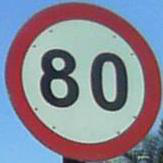

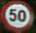

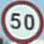

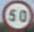

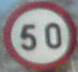

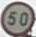

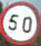

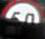

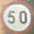

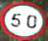

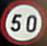

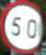

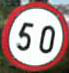

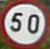

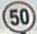

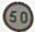

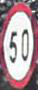

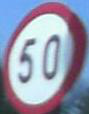

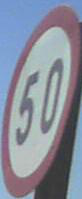

In [11]:
# print some cropped examples

for index,row in train_df[:20].iterrows():
    file = row.Img_Name
    image = Image.open("../data/train/%s_crop.jpg" % file[:-4], 'r')
#     print ("Filename: ", file)
#     print ("Bounding Box: (Top,Left,Width,Height)", row.Top, row.Left, row.Width, row.Height)
#     print ("Image Dimensions: ", image.size)
#     width, height = image.size
#     right = (row.Left + row.Width)
#     lower = (row.Top + row.Height)
#     box = (row.Left, row.Top, right, lower)
#     print ("Bounding Pixels: ", box)
    display(image)

___  
# Step 2: Standardize the cropped images
---

We know that the max width and height are **191 px by 244 px**. In order to simplify the following actions, we can define the standard input for image classification to be **250px by 250px**.

Prior Shape:  (199, 82, 3)


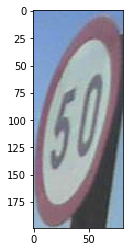

New Shape:  (250, 250, 3)


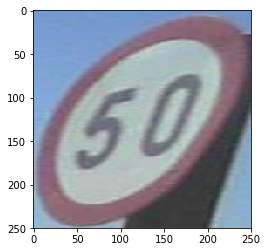

In [48]:
# test on an example crop

# load image
file = train_df[19:20]["Img_Name"].values[0][:-4]
image = cv2.imread("../data/train/%s_crop.jpg" % file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h,w = image.shape[:2]
print("Prior Shape: ", image.shape)
plt.imshow(image,cmap='gray')
plt.show()

# transform
image_trans = cv2.resize(image,(250, 250), interpolation = cv2.INTER_CUBIC)
h,w = image_trans.shape[:2]
print("New Shape: ", image_trans.shape)
plt.imshow(image_trans,cmap='gray')
plt.show()


In [53]:
# transform all cropped images and save them

def trans250(path, file):
    '''
    To be used inside a for loop (iterating over each row).
    Please generate cropped images using savecrop() first.
    Takes cropped images, transforms them to 250px by 250px and saves them
    Use example: ` boxcrop("../data/train/","02-25 13.26.44.jpg") `
                 --> this will take 02-25 13.26.44_crop.jpg
                 --> and create 02-25 13.26.44_crop_trans.jpg
    '''

    image = cv2.imread(path+"%s_crop.jpg" % file[:-4])
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_trans = cv2.resize(image,(250, 250), interpolation = cv2.INTER_CUBIC)
    cv2.imwrite( path+"%s_crop_trans.jpg" % file[:-4], image_trans )
    
for index,row in train_df.iterrows():
    trans250("../data/train/",row.Img_Name)
    #print ("squashing " + row.Img_Name + "...")

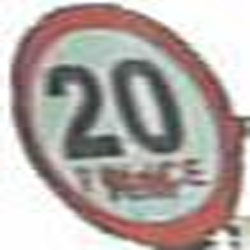

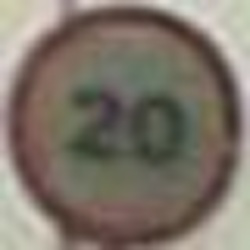

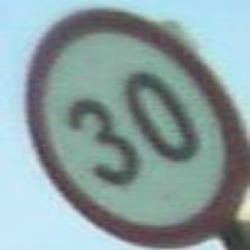

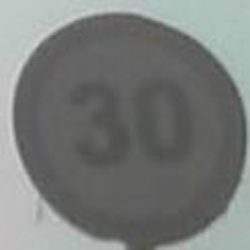

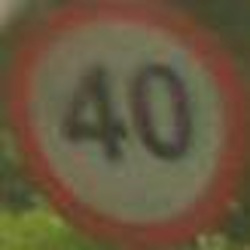

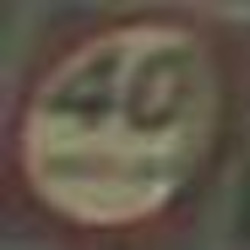

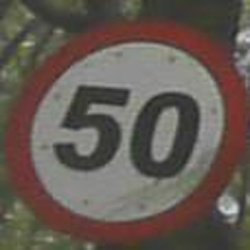

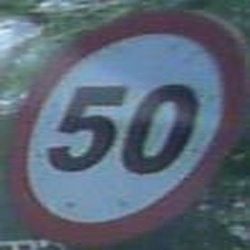

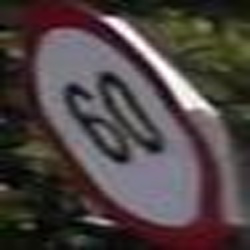

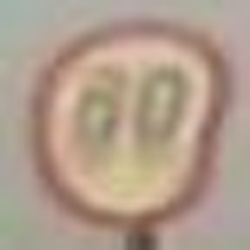

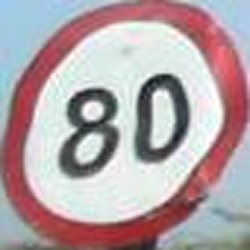

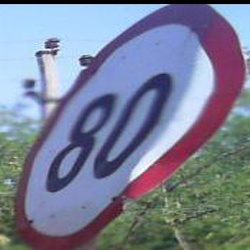

In [66]:
# check some of the standardized images

for index,row in train_df[train_df["Label"]=="Speed Limit 20"][:2].iterrows():
    file = row.Img_Name
    image = Image.open("../data/train/%s_crop_trans.jpg" % file[:-4], 'r')
    display(image)
    
for index,row in train_df[train_df["Label"]=="Speed Limit 30"][5:7].iterrows():
    file = row.Img_Name
    image = Image.open("../data/train/%s_crop_trans.jpg" % file[:-4], 'r')
    display(image)
    
for index,row in train_df[train_df["Label"]=="Speed Limit 40"][11:13].iterrows():
    file = row.Img_Name
    image = Image.open("../data/train/%s_crop_trans.jpg" % file[:-4], 'r')
    display(image)

for index,row in train_df[train_df["Label"]=="Speed Limit 50"][21:23].iterrows():
    file = row.Img_Name
    image = Image.open("../data/train/%s_crop_trans.jpg" % file[:-4], 'r')
    display(image)

for index,row in train_df[train_df["Label"]=="Speed Limit 60"][41:43].iterrows():
    file = row.Img_Name
    image = Image.open("../data/train/%s_crop_trans.jpg" % file[:-4], 'r')
    display(image)
    
for index,row in train_df[train_df["Label"]=="Speed Limit 80"][31:33].iterrows():
    file = row.Img_Name
    image = Image.open("../data/train/%s_crop_trans.jpg" % file[:-4], 'r')
    display(image)

---  
# Step 3: Expand dataset
###  (flipping, noise, projection + rotation)
---